In [6]:
import time
from functools import partial
from os.path import expanduser, join
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import FunctionTransformer

from flows4manufacturing.common.flows import (
    AffineCouplingBlock,
    NormalizingFlow,
    SequentialBijector,
)
from flows4manufacturing.parameter_estimation.bayesflow import (
    BayesFlow,
    evaluate_predicted_obs,
)
from flows4manufacturing.parameter_estimation.estimate import (
    ParamNet,
    SummaryNet,
    load_milling_data,
    stepwise_model,
)


In [2]:
num_params = 2
context_len = 32
scale_translate_hidden = 32
num_blocks = 8
gru_layers = 2
summary_net = SummaryNet(gru_layers, context_len)
mask = torch.arange(num_params) % 2 == 0
bij = SequentialBijector(
    *[
        AffineCouplingBlock(
            ParamNet(num_params, context_len, scale_translate_hidden),
            mask if i % 2 == 0 else ~mask,
        )
        for i in range(num_blocks)
    ]
)
flow = NormalizingFlow(bij, (num_params,))
bayes_flow = BayesFlow(summary_net, flow)

In [3]:
MODEL_CKPT = "./rfr00.pt"
bayes_flow.load_state_dict(torch.load(MODEL_CKPT, map_location="cpu"))

<All keys matched successfully>

In [4]:
all_data = load_milling_data(expanduser(join("~", "mill.mat")))
indexed = zip(all_data, range(len(all_data)))
milling_data = [x for x in indexed if x[0].shape[0] >= 10]
print([len(x[0]) for x in milling_data])
print([x[1] for x in milling_data])
milling_data = [x[0] for x in milling_data]
milling_data = [all_data[i] for i in [0, 1, 2, 9, 10, 11, 12]]
print([len(x) for x in milling_data])


[17, 14, 14, 10, 23, 15, 15]
[0, 1, 2, 9, 10, 11, 12]
[17, 14, 14, 10, 23, 15, 15]


In [5]:
plt.rc("font", size=6.0)


def plot_milling_prognosis(
    obs: np.ndarray,
    num_samples: int = 1000,
    prognosis_start: int = 10,
    ax=None,
    legend: bool = True,
    title: Optional[str] = None
):
    data_sim_model = partial(stepwise_model, noise_power=0.002)
    identity = FunctionTransformer(lambda x: x, inverse_func=lambda x: x)
    padded = torch.zeros((25,))
    padded[: obs.shape[0]] = torch.tensor(obs)
    x, mean_y, y, _ = evaluate_predicted_obs(
        torch.tensor(obs),
        data_sim_model,
        bayes_flow,
        identity,
        identity,
        num_samples,
        prognosis_start,
    )
    mean_y = mean_y.detach().cpu()
    y = y.cpu()
    # Compute the 90-10 interval for the prognosis
    top90 = np.quantile(y, 0.9, axis=0)
    bottom10 = np.quantile(y, 0.1, axis=0)
    median = np.quantile(y, 0.5, axis=0)
    rmse = np.sqrt(((obs[prognosis_start:] - median[1:]) ** 2).mean())

    if ax is None:
        fig, ax = plt.subplots(figsize=(3.3, 2))
    # ax.plot(x, y.T, color="b", alpha=0.01)
    ax.plot(obs, label="Actual", color="r", marker="o", markersize=2)
    ax.plot(x, top90, color="k", ls="--", label="90%")
    ax.plot(x, median, color="k", ls=":", label="50%")
    ax.plot(x, bottom10, color="k", ls="--", label="10%")
    ax.set_ylim(0, None)
    ax.set_xlim(0, obs.shape[0] - 1)
    ax.set_xlabel("Run Index")
    ax.set_ylabel("Flank Wear (mm)")
    ax.set_xticks(np.arange(obs.shape[0], step=4))
    if legend:
        ax.legend(loc="upper left")
    if title:
        ax.set_title(title)
    return rmse


def milling_rmse(
    model: BayesFlow, obs: np.array, num_samples: int = 1000, prognosis_start: int = 10
):
    data_sim_model = partial(stepwise_model, noise_power=0.002)
    identity = FunctionTransformer(lambda x: x, inverse_func=lambda x: x)
    x, mean_y, y, _ = evaluate_predicted_obs(
        torch.tensor(obs),
        data_sim_model,
        model,
        identity,
        identity,
        num_samples,
        prognosis_start,
    )
    mean_y = mean_y.detach().cpu()
    y = y.cpu()
    median = np.quantile(y, 0.5, axis=0)
    rmse = np.sqrt(((obs[prognosis_start:] - median[1:]) ** 2).mean())
    return rmse


In [16]:
def compute_rmse(model: BayesFlow, checkpoint: str, obs: np.ndarray):
    model.load_state_dict(torch.load(checkpoint, map_location="cpu"))
    rmse = milling_rmse(model, obs, num_samples=10000, prognosis_start=10)
    return rmse


checkpoints = [f"rfr{i:02d}.pt" for i in range(5)]
val_curves = [0, 2, 6]
test_curves = [1, 4, 5]

val_rmse = []
test_rmse = []
for i in val_curves:
    rmse = np.array(
        [compute_rmse(bayes_flow, x, milling_data[i]) for x in checkpoints]
    )
    val_rmse.append(f"{rmse.mean():0.3f}±{rmse.std():0.3f} mm")

for i in test_curves:
    rmse = np.array(
        [compute_rmse(bayes_flow, x, milling_data[i]) for x in checkpoints]
    )
    test_rmse.append(f"{rmse.mean():0.3f}±{rmse.std():0.3f} mm")

val_rmse + test_rmse

c:\Users\Matthew\OneDrive - University of Kentucky\phd\code\motor-flow\bayesflow.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_t = torch.tensor(
c:\Users\Matthew\OneDrive - University of Kentucky\phd\code\motor-flow\bayesflow.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(


['0.086±0.003 mm',
 '0.058±0.002 mm',
 '0.078±0.011 mm',
 '0.047±0.004 mm',
 '0.043±0.009 mm',
 '0.029±0.006 mm']

In [24]:
times = []
for _ in range(25):
    tic = time.perf_counter()
    obs = torch.tensor(milling_data[0][:10], dtype=torch.float)
    _ = bayes_flow.sample(10000, obs.unsqueeze(0))
    toc = time.perf_counter()
    times.append(toc - tic)
print(f"{np.mean(times):.3f}+/-{np.std(times):.3f} s")

0.023+/-0.003 s


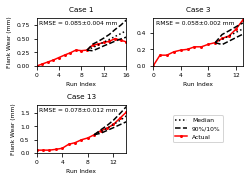

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3.4, 2.5))
axs = [ax for row in axs for ax in row]
_ = plot_milling_prognosis(milling_data[0], 1000, 10, axs[0], legend=False, title="Case 1")
_ = plot_milling_prognosis(milling_data[2], 1000, 10, axs[1], legend=False, title="Case 3")
_ = plot_milling_prognosis(milling_data[6], 1000, 10, axs[2], legend=False, title="Case 13")

for i in range(3):
    axs[i].text(0.03, 0.85, "RMSE = " + val_rmse[i], transform=axs[i].transAxes)

axs[1].set_ylabel("")
axs[3].axis("off")
artists = [
    plt.Line2D([], [], color="k", ls=":", label="Median"),
    plt.Line2D([], [], color="k", ls="--", label="90%/10%"),
    plt.Line2D([], [], color="r", ls="-", marker="o", markersize=2, label="Actual"),

]
plt.legend(handles=artists, loc="center")
fig.tight_layout()
# plt.savefig("../../papers/2023_namrc/msec/figures/train-milling.pdf", bbox_inches="tight")
plt.show()


c:\Users\Matthew\OneDrive - University of Kentucky\phd\code\motor-flow\bayesflow.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_t = torch.tensor(
c:\Users\Matthew\OneDrive - University of Kentucky\phd\code\motor-flow\bayesflow.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(


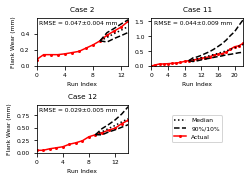

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3.4, 2.5))
axs = [ax for row in axs for ax in row]
_ = plot_milling_prognosis(milling_data[1], 1000, 10, axs[0], legend=False, title="Case 2")
_ = plot_milling_prognosis(milling_data[4], 1000, 10, axs[1], legend=False, title="Case 11")
_ = plot_milling_prognosis(milling_data[5], 1000, 10, axs[2], legend=False, title="Case 12")
for i in range(3):
    axs[i].text(0.03, 0.85, "RMSE = " + test_rmse[i], transform=axs[i].transAxes)
axs[1].set_ylabel("")
axs[3].axis("off")
artists = [
    plt.Line2D([], [], color="k", ls=":", label="Median"),
    plt.Line2D([], [], color="k", ls="--", label="90%/10%"),
    plt.Line2D([], [], color="r", ls="-", marker="o", markersize="2", label="Actual"),
]
plt.legend(handles=artists, loc="center")
fig.tight_layout()
# plt.savefig("../../papers/2023_namrc/msec/figures/test-milling.pdf", bbox_inches="tight")
plt.show()